In [ ]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models/qwen-image-edit"
OUTPUT_PATH = f"{PROJECT_PATH}/output"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Target configuration
TARGET_NAME = "153_B"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{TARGET_NAME}"

# Input image path (from project resource folder)
INPUT_IMAGE = f"{CODE_PATH}/resource/{TARGET_NAME}.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml skan rdp

import shutil
import subprocess

# Clean and clone repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# Display latest commit info
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    commit_time, commit_msg = commit_info.stdout.strip().split('|', 1)
    print(f"Latest commit: {commit_time.split()[0]} - {commit_msg}")

# Add to Python path and reload modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Clear custom modules from cache
for base in ['sam_processor', 'svglib', 'utils']:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

# Create necessary directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

print("Setup complete!")

Repository successfully cloned
Latest commit: 2025-10-03 - opt uniform_line_thickness
Setup complete!


Clearing GPU memory...
Loading model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded with CPU offload
Edit prompt: Transform this girl's long ponytail into a chic, shoulder-length layered cut. Remove all long flowing hair. Ensure clean, continuous lines without artifacts. Maintain the exact same minimalist black line art style on pure white background. Convert all lines to uniform deep black color with consistent thickness. Keep all unmodified parts with their original line structure, position, and curvature. Ensure all lines are clear, smooth, and of the same color depth and weight. Avoid any variations in line weight or opacity within the new image.
Negative prompt: inconsistent line thickness, varying line weight, gradient lines, non-uniform line opacity, thick and thin lines mixed, uneven line density, color variations in lines, non-black lines, colored lines, gradient effects, white background noise, speckles, dots, artifacts, jagged edges, broken lines, discontinuous lines, blurry lines, low quality, distorted, messy


  0%|          | 0/30 [00:00<?, ?it/s]

Edited image saved: /content/drive/MyDrive/SVGEditor/output/153_B/1.153_B_qwen_edit.png


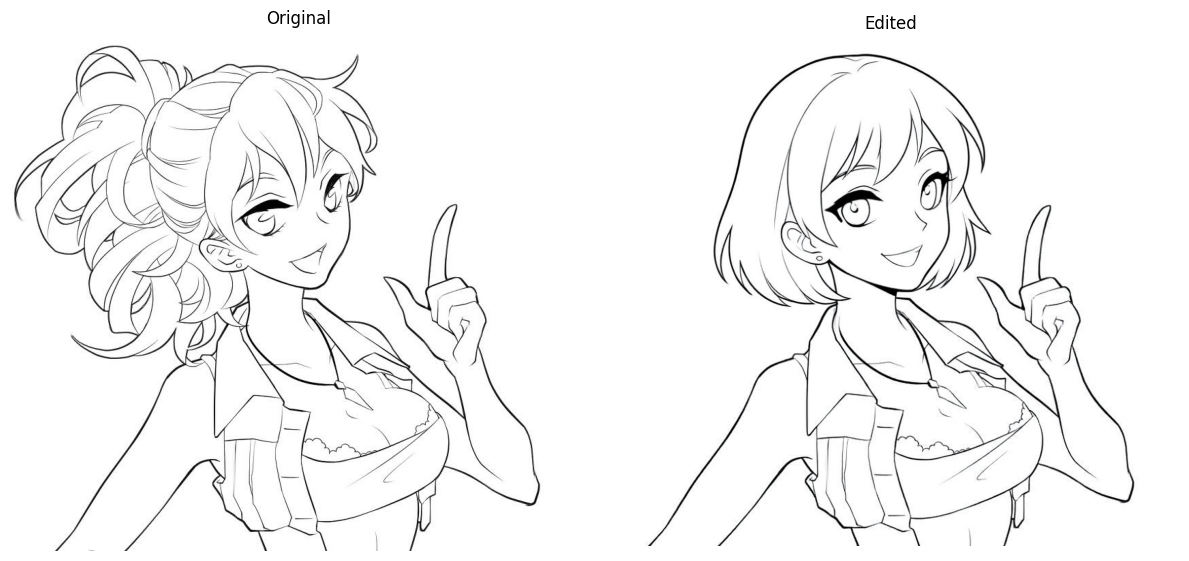

In [ ]:
# Image Editing with Qwen

import torch
import gc
from PIL import Image
from diffusers import QwenImageEditPipeline
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

def load_qwen_model():
    """Load Qwen image editing model"""
    print("Clearing GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()

    print("Loading model...")
    pipeline = QwenImageEditPipeline.from_pretrained(
        MODEL_PATH,
        local_files_only=True,
        torch_dtype=torch.bfloat16
    )
    pipeline.set_progress_bar_config(disable=None)
    pipeline.enable_model_cpu_offload()
    print("✅ Model loaded with CPU offload")
    return pipeline

def process_image_with_qwen(pipeline, image, prompt, negative_prompt):
    """Process image with Qwen model"""
    inputs = {
        "image": image,
        "prompt": prompt,
        "generator": torch.manual_seed(0),
        "true_cfg_scale": 4.0,
        "negative_prompt": negative_prompt,
        "num_inference_steps": 30,
    }

    with torch.inference_mode():
        output = pipeline(**inputs)
        output_image = output.images[0]

    # Save edited image
    output_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_qwen_edit.png"
    output_image.save(output_path)
    print(f"Edited image saved: {output_path}")

    return output_image

# Execute image editing
pipeline = load_qwen_model()
original_image = Image.open(INPUT_IMAGE)
edit_prompt = get_prompt(TARGET_NAME)
negative_prompt = get_negative_prompt()
print(f"Edit prompt: {edit_prompt}")
print(f"Negative prompt: {negative_prompt}")

edited_image = process_image_with_qwen(pipeline, original_image, edit_prompt, negative_prompt)

plot_images([(original_image, "Original"), (edited_image, "Edited")])

In [ ]:
# Cleanup
del pipeline
torch.cuda.empty_cache()
gc.collect()
print("Processing completed")

Processing completed


IMAGE PREPROCESSING PIPELINE
Parameters:
  - Binary threshold: 180
  - Line thickness: target=2px, preserve=0.5
Loading image: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_qwen_edit.png
Original image shape: (960, 1088)

Binarization: threshold=180
White pixels: 47516

STEP 1: Fill-to-Outline Conversion
Processed 3 thick filled regions

STEP 2: Uniform Line Thickness
Uniform line thickness: target_width=2px, preserve_threshold=0.5
Preserved 0 thin lines, rebuilt 36 thick lines
White pixels: 46255 → 46777

Saving intermediate files...
✅ All files saved to: /content/drive/MyDrive/SVGEditor/output/153_B

✅ PREPROCESSING COMPLETED!


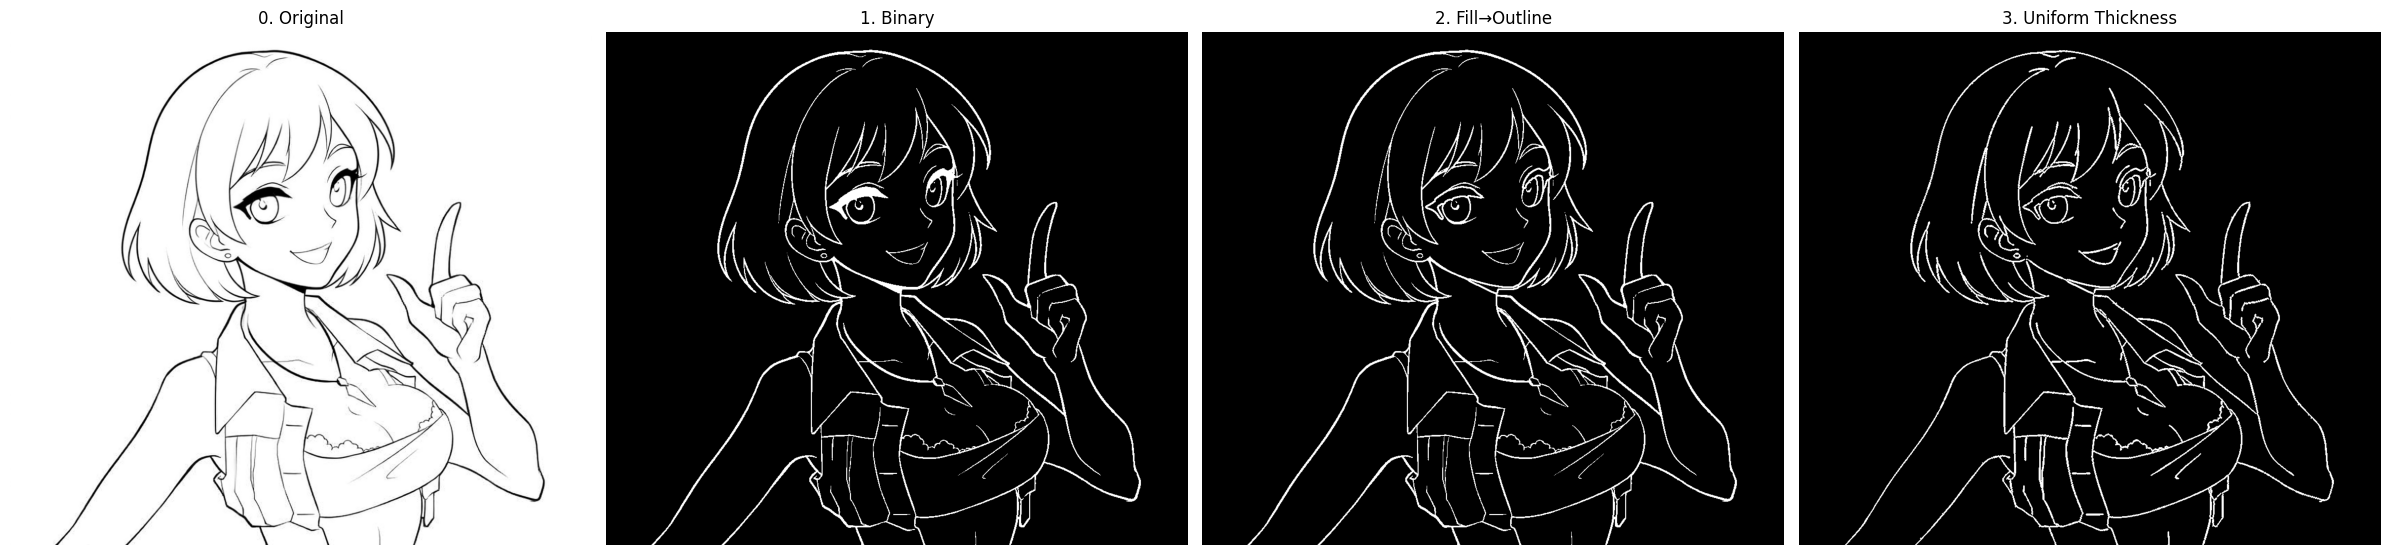


Next step: Skeleton extraction for SVG path generation


In [ ]:
# Fill-to-Outline Processing with Visualization

import cv2
import numpy as np
from PIL import Image
import os
from utils.plot_utils import plot_images
from utils.image_utils import uniform_line_thickness

# Processing parameters
BINARY_THRESHOLD = 180
THICKNESS_THRESHOLD = 5
MIN_FILL_AREA = 300
OUTLINE_WIDTH = 2

# Line thickness uniformization
TARGET_WIDTH = 2           # Target line width in pixels (3-5 recommended)
PRESERVE_THRESHOLD = 0.5   # Preserve lines thinner than target_width * 0.5


def convert_fills_to_outlines(binary_img):
    """Convert thick filled regions to outline borders"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (THICKNESS_THRESHOLD, THICKNESS_THRESHOLD))
    eroded = cv2.erode(binary_img, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded)

    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < MIN_FILL_AREA:
            continue

        component_mask = (labels == i).astype(np.uint8) * 255
        dilated_mask = cv2.dilate(component_mask, kernel)
        original_fill = cv2.bitwise_and(binary_img, dilated_mask)
        outline_mask = create_outline_from_fill(original_fill)

        result_img = cv2.bitwise_and(result_img, cv2.bitwise_not(dilated_mask))
        result_img = cv2.bitwise_or(result_img, outline_mask)
        processed_count += 1

    print(f"Processed {processed_count} thick filled regions")
    return result_img


def create_outline_from_fill(fill_mask):
    """Generate outline from fill region"""
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)
    for contour in contours:
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)
    return outline_mask


def process_image_preprocessing():
    """
    2-step image preprocessing:
    Step 1: Fill-to-outline conversion (remove filled regions)
    Step 2: Uniform line thickness (skeleton-based reconstruction)
    """
    input_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_qwen_edit.png")

    if not os.path.exists(input_path):
        print(f"ERROR: Input file not found: {input_path}")
        return None

    print(f"Loading image: {input_path}")
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")

    # Initial binarization
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    print(f"\nBinarization: threshold={BINARY_THRESHOLD}")
    print(f"White pixels: {np.sum(binary > 0)}")

    # Save intermediate results
    results = {
        'original': img,
        'binary': binary
    }

    # Step 1: Fill-to-outline conversion
    print(f"\n{'='*60}")
    print("STEP 1: Fill-to-Outline Conversion")
    print(f"{'='*60}")
    step1_result = convert_fills_to_outlines(binary)
    results['step1_outline'] = step1_result

    # Step 2: Uniform line thickness
    print(f"\n{'='*60}")
    print("STEP 2: Uniform Line Thickness")
    print(f"{'='*60}")
    step2_result = uniform_line_thickness(
        step1_result,
        target_width=TARGET_WIDTH,
        preserve_threshold=PRESERVE_THRESHOLD
    )
    results['step2_uniform'] = step2_result

    # Save all intermediate files
    print(f"\n{'='*60}")
    print("Saving intermediate files...")
    print(f"{'='*60}")

    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_0_original.png"), img)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_1_binary.png"), binary)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_2_outline.png"), step1_result)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_3_uniform.png"), step2_result)

    print(f"✅ All files saved to: {TARGET_OUTPUT_PATH}")

    return results


# Execute preprocessing
print("="*60)
print("IMAGE PREPROCESSING PIPELINE")
print("="*60)
print(f"Parameters:")
print(f"  - Binary threshold: {BINARY_THRESHOLD}")
print(f"  - Line thickness: target={TARGET_WIDTH}px, preserve={PRESERVE_THRESHOLD}")
print("="*60)

results = process_image_preprocessing()

if results is not None:
    print(f"\n{'='*60}")
    print("✅ PREPROCESSING COMPLETED!")
    print(f"{'='*60}")

    # Visualize all steps
    images_to_plot = [
        (Image.fromarray(results['original']).convert('RGB'), "0. Original"),
        (Image.fromarray(results['binary']).convert('RGB'), "1. Binary"),
        (Image.fromarray(results['step1_outline']).convert('RGB'), "2. Fill→Outline"),
        (Image.fromarray(results['step2_uniform']).convert('RGB'), "3. Uniform Thickness")
    ]

    plot_images(images_to_plot)

    print("\nNext step: Skeleton extraction for SVG path generation")
else:
    print("\n❌ PREPROCESSING FAILED!")

SKELETON EXTRACTION WITH ASYMMETRIC SMOOTHING
Parameters:
  - Dilation: kernel=2, iterations=2
  - Erosion: kernel=2, iterations=1
  - Min branch length: 3px
  - Endpoint connection distance: 8px
Loading image: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_3_uniform.png
Image shape: (960, 1088)

PHASE 1: Initial Skeleton Extraction
Input shape: (960, 1088)
White pixels: 46777

Step 1: Skeletonization...
Skeleton pixels: 14139

Step 2: Connecting endpoints...
Connected 10 endpoint pairs
Pixels after connection: 14171

Step 3: Removing short branches...
Removed 2 short branches
Final skeleton pixels: 14169

PHASE 2: Skeleton Smoothing (Asymmetric Dilate+Erode)
Dilation (kernel=2, iter=2): 48029 pixels
Erosion (kernel=2, iter=1): 31298 pixels

PHASE 3: Re-extract Skeleton (from smoothed)
Input shape: (960, 1088)
White pixels: 31298

Step 1: Skeletonization...
Skeleton pixels: 13905

Step 2: Connecting endpoints...
Connected 2 endpoint pairs
Pixels after connection: 13906

Step 3: Re

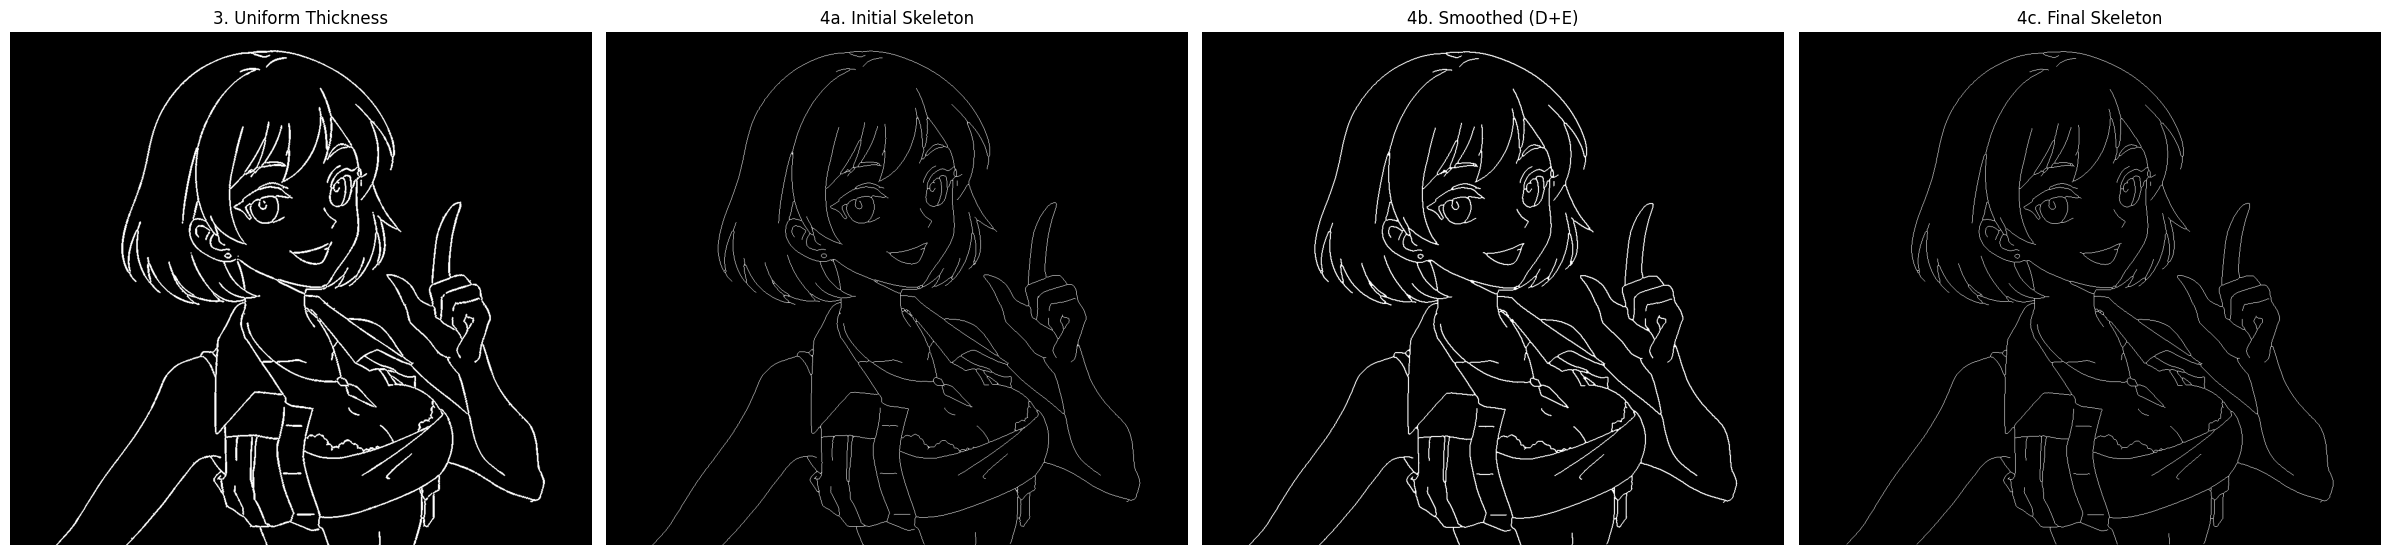


Next step: SVG path generation from skeleton


In [ ]:
# Skeleton Extraction with Morphological Smoothing

import cv2
import numpy as np
from PIL import Image
from skimage.morphology import skeletonize
import os
from utils.plot_utils import plot_images
from utils.image_utils import morphological_smooth

# Skeletonization parameters
SKELETON_MIN_LENGTH = 3       # Minimum skeleton branch length (pixels)
ENDPOINT_CONNECTION_DIST = 8  # Maximum distance to connect nearby endpoints (pixels)

# Skeleton smoothing parameters (dilate more, erode less)
SKELETON_DILATE_KERNEL = 2    # Dilation kernel size (larger → more smoothing)
SKELETON_DILATE_ITERATIONS = 2 # Dilation iterations
SKELETON_ERODE_KERNEL = 2     # Erosion kernel size (smaller than dilation)
SKELETON_ERODE_ITERATIONS = 1  # Erosion iterations (less than dilation)


def find_skeleton_endpoints(skeleton):
    """Find skeleton endpoints (pixels with only one neighbor)"""
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)

    neighbor_count = cv2.filter2D(skeleton.astype(np.uint8), -1, kernel)
    endpoints = np.where((skeleton == 1) & (neighbor_count == 11))

    return list(zip(endpoints[0], endpoints[1]))


def connect_nearby_endpoints(skeleton):
    """Connect endpoints that are close to each other"""
    endpoints = find_skeleton_endpoints(skeleton)
    result = skeleton.astype(np.uint8)
    connections_made = 0

    for i, ep1 in enumerate(endpoints):
        for ep2 in endpoints[i+1:]:
            distance = np.linalg.norm(np.array(ep1) - np.array(ep2))

            if distance <= ENDPOINT_CONNECTION_DIST:
                cv2.line(result, ep1[::-1], ep2[::-1], 1, 1)
                connections_made += 1

    print(f"Connected {connections_made} endpoint pairs")
    return result.astype(bool)


def remove_short_branches(skeleton, min_length=None):
    """Remove short skeleton branches (noise/spurs)"""
    if min_length is None:
        min_length = SKELETON_MIN_LENGTH

    num_labels, labels = cv2.connectedComponents(skeleton.astype(np.uint8))
    result = np.zeros_like(skeleton)
    removed_count = 0

    for i in range(1, num_labels):
        component = (labels == i)
        component_size = np.sum(component)

        if component_size >= min_length:
            result[component] = 1
        else:
            removed_count += 1

    print(f"Removed {removed_count} short branches")
    return result


def extract_skeleton(binary_img):
    """
    Extract skeleton from binary image
    Pipeline: skeletonize → connect endpoints → remove short branches
    """
    print(f"Input shape: {binary_img.shape}")
    print(f"White pixels: {np.sum(binary_img > 0)}")

    # Step 1: Skeletonization
    print("\nStep 1: Skeletonization...")
    skeleton = skeletonize(binary_img > 0)
    print(f"Skeleton pixels: {np.sum(skeleton)}")

    # Step 2: Connect nearby endpoints
    print("\nStep 2: Connecting endpoints...")
    skeleton_connected = connect_nearby_endpoints(skeleton)
    print(f"Pixels after connection: {np.sum(skeleton_connected)}")

    # Step 3: Remove short branches
    print("\nStep 3: Removing short branches...")
    skeleton_cleaned = remove_short_branches(skeleton_connected)
    print(f"Final skeleton pixels: {np.sum(skeleton_cleaned)}")

    return skeleton_cleaned


def smooth_skeleton_asymmetric(skeleton_img):
    """
    Asymmetric smoothing: dilate more than erode to expand coverage
    This helps remove jaggedness while preserving overall structure
    """
    # Dilate with larger kernel and more iterations
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                              (SKELETON_DILATE_KERNEL, SKELETON_DILATE_KERNEL))
    dilated = cv2.dilate(skeleton_img, dilate_kernel, iterations=SKELETON_DILATE_ITERATIONS)
    print(f"Dilation (kernel={SKELETON_DILATE_KERNEL}, iter={SKELETON_DILATE_ITERATIONS}): {np.sum(dilated > 0)} pixels")

    # Erode with smaller kernel and fewer iterations
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (SKELETON_ERODE_KERNEL, SKELETON_ERODE_KERNEL))
    smoothed = cv2.erode(dilated, erode_kernel, iterations=SKELETON_ERODE_ITERATIONS)
    print(f"Erosion (kernel={SKELETON_ERODE_KERNEL}, iter={SKELETON_ERODE_ITERATIONS}): {np.sum(smoothed > 0)} pixels")

    return smoothed


def process_skeletonization():
    """
    Main skeletonization pipeline with smoothing:
    1. Extract skeleton (original method)
    2. Smooth skeleton (dilate > erode)
    3. Re-extract skeleton (on smoothed result)
    """
    # Load uniform thickness result from previous step
    input_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_3_uniform.png")

    if not os.path.exists(input_path):
        print(f"ERROR: Input file not found: {input_path}")
        print("Please run the preprocessing step first")
        return None

    print(f"Loading image: {input_path}")
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    print(f"Image shape: {img.shape}")

    # Results dictionary for visualization
    results = {}

    # Phase 1: Extract skeleton (original method)
    print("\n" + "="*60)
    print("PHASE 1: Initial Skeleton Extraction")
    print("="*60)
    skeleton_initial = extract_skeleton(img)
    skeleton_initial_uint8 = (skeleton_initial * 255).astype(np.uint8)
    results['skeleton_initial'] = skeleton_initial_uint8

    # Phase 2: Smooth the skeleton
    print("\n" + "="*60)
    print("PHASE 2: Skeleton Smoothing (Asymmetric Dilate+Erode)")
    print("="*60)
    skeleton_smoothed = smooth_skeleton_asymmetric(skeleton_initial_uint8)
    results['skeleton_smoothed'] = skeleton_smoothed

    # Phase 3: Re-extract skeleton from smoothed result
    print("\n" + "="*60)
    print("PHASE 3: Re-extract Skeleton (from smoothed)")
    print("="*60)
    skeleton_final = extract_skeleton(skeleton_smoothed)
    skeleton_final_uint8 = (skeleton_final * 255).astype(np.uint8)
    results['skeleton_final'] = skeleton_final_uint8

    # Calculate distance transform (for line width estimation)
    distance_transform = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    distance_normalized = cv2.normalize(distance_transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    results['distance_transform'] = distance_normalized
    print(f"\nDistance transform max: {distance_transform.max():.2f}px")

    # Save all intermediate results
    print("\n" + "="*60)
    print("Saving results...")
    print("="*60)

    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_skeleton_initial.png"), skeleton_initial_uint8)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_skeleton_smoothed.png"), skeleton_smoothed)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_skeleton_final.png"), skeleton_final_uint8)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_distance.png"), distance_normalized)

    print(f"✅ All files saved to: {TARGET_OUTPUT_PATH}")

    return results


# Execute skeletonization
print("="*60)
print("SKELETON EXTRACTION WITH ASYMMETRIC SMOOTHING")
print("="*60)
print(f"Parameters:")
print(f"  - Dilation: kernel={SKELETON_DILATE_KERNEL}, iterations={SKELETON_DILATE_ITERATIONS}")
print(f"  - Erosion: kernel={SKELETON_ERODE_KERNEL}, iterations={SKELETON_ERODE_ITERATIONS}")
print(f"  - Min branch length: {SKELETON_MIN_LENGTH}px")
print(f"  - Endpoint connection distance: {ENDPOINT_CONNECTION_DIST}px")
print("="*60)

results = process_skeletonization()

if results is not None:
    print(f"\n{'='*60}")
    print("✅ SKELETON EXTRACTION COMPLETED!")
    print(f"{'='*60}")

    # Visualize all phases
    uniform_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_3_uniform.png")
    uniform_img = cv2.imread(uniform_path, cv2.IMREAD_GRAYSCALE)

    images_to_plot = [
        (Image.fromarray(uniform_img).convert('RGB'), "3. Uniform Thickness"),
        (Image.fromarray(results['skeleton_initial']).convert('RGB'), "4a. Initial Skeleton"),
        (Image.fromarray(results['skeleton_smoothed']).convert('RGB'), "4b. Smoothed (D+E)"),
        (Image.fromarray(results['skeleton_final']).convert('RGB'), "4c. Final Skeleton"),
    ]

    plot_images(images_to_plot)

    print("\nNext step: SVG path generation from skeleton")
else:
    print("\n❌ SKELETON EXTRACTION FAILED!")

=== SVG Conversion ===
Loaded skeleton: (960, 1088), pixels: 13906
Extracted 327 paths
Raw SVG saved: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_5_raw.svg


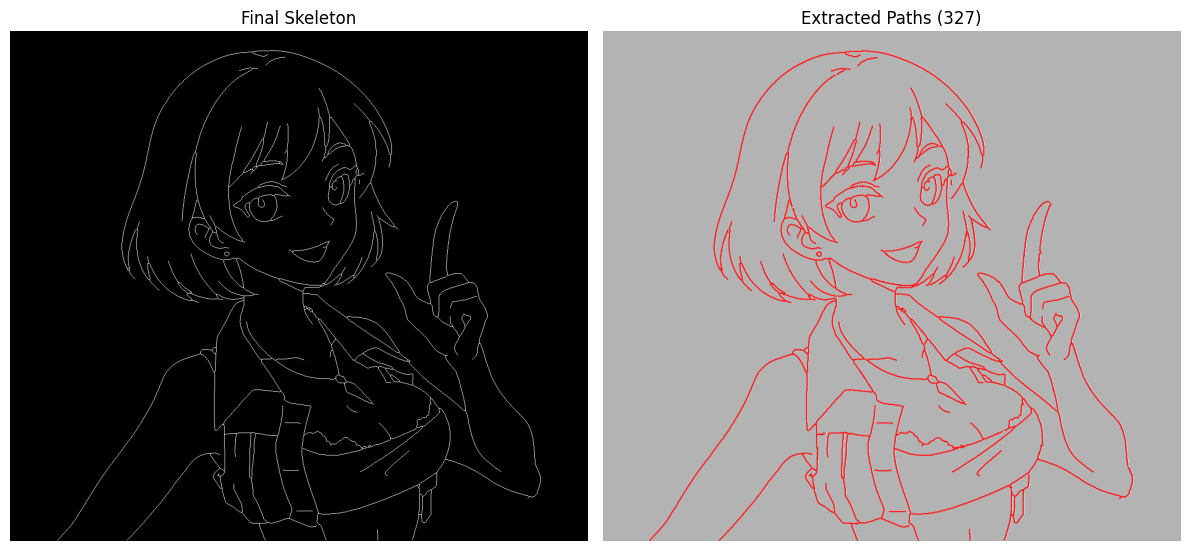

In [59]:
# ==================== Cell 6: Skeleton to SVG ====================

import cv2
import numpy as np
from skimage.measure import label, regionprops
from svglib.svg import SVG
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.geom import Bbox
import matplotlib.pyplot as plt

def extract_paths_from_skeleton(skeleton):
    """Extract ordered paths from skeleton"""
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    labeled = label(skeleton_binary)
    regions = regionprops(labeled)

    paths = []
    for region in regions:
        coords = region.coords
        if len(coords) < 2:
            continue

        # Find endpoints
        def count_neighbors(pt, all_coords):
            return sum(1 for c in all_coords
                      if abs(c[0]-pt[0]) <= 1 and abs(c[1]-pt[1]) <= 1 and tuple(c) != tuple(pt))

        endpoints = [p for p in coords if count_neighbors(p, coords) == 1]
        remaining = set(tuple(c) for c in coords)

        # Trace paths from endpoints
        while remaining:
            start = None
            for ep in endpoints:
                if tuple(ep) in remaining:
                    start = ep
                    break
            if start is None:
                start = next(iter(remaining))

            # Build path
            path_coords = [(int(start[1]), int(start[0]))]
            remaining.remove(tuple(start))
            cur = start

            while remaining:
                nxt = next((c for c in remaining
                           if abs(c[0]-cur[0]) <= 1 and abs(c[1]-cur[1]) <= 1), None)
                if nxt is None:
                    break
                path_coords.append((int(nxt[1]), int(nxt[0])))
                remaining.remove(nxt)
                cur = nxt

            if len(path_coords) >= 2:
                paths.append(path_coords)

    return paths

def convert_to_svg(paths, image_shape):
    """Convert paths to SVG"""
    svg_paths = []
    for path in paths:
        d = f"M {path[0][0]:.1f} {path[0][1]:.1f}"
        for x, y in path[1:]:
            d += f" L {x:.1f} {y:.1f}"
        path_group = SVGPath.from_str(d, add_closing=False)
        svg_paths.extend(path_group.svg_paths)

    viewbox = Bbox(0, 0, image_shape[1], image_shape[0])
    group = SVGPathGroup(svg_paths, fill=False, stroke_width=2.0)

    for sp in group.svg_paths:
        if not hasattr(sp, 'filling'):
            sp.filling = 0

    return SVG([group], viewbox=viewbox)

def process_svg_conversion():
    """Convert skeleton to SVG"""
    # Load final skeleton
    skeleton_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_skeleton_final.png")

    if not os.path.exists(skeleton_path):
        print(f"Error: Skeleton not found at {skeleton_path}")
        return None

    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE)
    print(f"Loaded skeleton: {skeleton.shape}, pixels: {np.sum(skeleton > 0)}")

    # Extract paths
    paths = extract_paths_from_skeleton(skeleton)
    print(f"Extracted {len(paths)} paths")

    if not paths:
        print("Warning: No paths extracted")
        return None

    # Convert to SVG
    svg = convert_to_svg(paths, skeleton.shape)
    svg_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_5_raw.svg")
    svg.save_svg(svg_path, coordinate_precision=1)
    print(f"Raw SVG saved: {svg_path}")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(skeleton, cmap='gray')
    axes[0].set_title('Final Skeleton')
    axes[0].axis('off')

    axes[1].imshow(skeleton, cmap='gray', alpha=0.3)
    for path in paths:
        path_array = np.array(path)
        axes[1].plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=1, alpha=0.8)
    axes[1].set_title(f'Extracted Paths ({len(paths)})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return svg

# Run SVG conversion
print("=== SVG Conversion ===")
svg_result = process_svg_conversion()